### Objective:
In this assignment, you'll work with the Amazon-Google product dataset to perform entity resolution. Your task is to identify and match records across the Amazon and Google product datasets that refer to the same product.

In [89]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import numpy as np
import sys
import math
np.set_printoptions(threshold=sys.maxsize)

stop = stopwords.words('english')

### Dataset: 
You'll use these files for this assignment:
- Amazon.csv
- Google.csv
- Amazon_GoogleProducts_perfectMapping.csv


### Question 1: Data Preprocessing and Feature Engineering

**1.1** : Load the three files using Pandas. How many unique products are there in (i) Amazon, and (ii) Google? (Hint: you will have to use the ground-truth links in the perfectMapping file to properly answer this question)


In [3]:
amazon = pd.read_csv(r'C:\Users\royer\Downloads\Amazon.csv', encoding='unicode_escape')
google = pd.read_csv(r'C:\Users\royer\Downloads\GoogleProducts.csv', encoding='unicode_escape')
a_g= pd.read_csv(r'C:\Users\royer\Downloads\Amzon_GoogleProducts_perfectMapping.csv', encoding='unicode_escape')

In [4]:
a_g["idAmazon"].value_counts

<bound method IndexOpsMixin.value_counts of 0       b000jz4hqo
1       b00004tkvy
2       b000g80lqo
3       b0006se5bq
4       b00021xhzw
           ...    
1295    b00005bigp
1296    b000h1df7w
1297    b000p9cr66
1298    b000p9cr66
1299    b000j588g4
Name: idAmazon, Length: 1300, dtype: object>

In [5]:
a_g["idGoogleBase"].value_counts

<bound method IndexOpsMixin.value_counts of 0       http://www.google.com/base/feeds/snippets/1844...
1       http://www.google.com/base/feeds/snippets/1844...
2       http://www.google.com/base/feeds/snippets/1844...
3       http://www.google.com/base/feeds/snippets/1842...
4       http://www.google.com/base/feeds/snippets/1843...
                              ...                        
1295    http://www.google.com/base/feeds/snippets/1773...
1296    http://www.google.com/base/feeds/snippets/1773...
1297    http://www.google.com/base/feeds/snippets/1772...
1298    http://www.google.com/base/feeds/snippets/1321...
1299    http://www.google.com/base/feeds/snippets/1773...
Name: idGoogleBase, Length: 1300, dtype: object>

**1.2**: Now, perform text preprocessing on the 'name', 'description', and 'manufacturer’ columns from both the Amazon and Google products datasets. Make sure to do the following preprocessing tasks:
- Convert all characters to lowercase.
- Remove special characters and punctuation, e.g., comma, parentheses, etc.
- Eliminate stop words, e.g.,”the”, “an”, “a”, etc.
- Convert empty strings and 'null' entries to actual null values.


After cleaning the text data, add three new columns to both of the dataframes: 'name_cleaned', 'description_cleaned', and 'manufacturer_cleaned'. These columns store the processed text.


(Although the following feature engineering processes are performed on the “cleaned” versions of the columns, it is always a good habit to not alter the original column, as it could be useful for spot-checks for your subsequent steps!)

In [6]:
def preprocess_text(text):
  if pd.isna(text):
    text=""
  else:
    text=text.lower()
    for punctuation in string.punctuation:
      text=text.replace(punctuation, ' ')
    text=nltk.word_tokenize(text)
    text = [t for t in text if not t in stop]
    text = [t for t in text if not t.isdigit()]
    text=' '.join(text)
  
  return text

amazon=amazon.rename(columns={'title':'name'})

for column in ['name', 'description', 'manufacturer']:
    amazon[column + '_cleaned'] = amazon[column].apply(preprocess_text)
    google[column + '_cleaned'] = google[column].apply(preprocess_text)



In [7]:
amazon.head(5)

,id,name,description,manufacturer,price,name_cleaned,description_cleaned,manufacturer_cleaned
0,b000jz4hqo,clickart 950 000 - premier image pack (dvd-rom),NaN,broderbund,0.00,clickart premier image pack dvd rom,,broderbund
1,b0006zf55o,ca international - arcserve lap/desktop oem 30pk,oem arcserve backup v11.1 win 30u for laptops ...,computer associates,0.00,ca international arcserve lap desktop oem 30pk,oem arcserve backup v11 win 30u laptops desktops,computer associates
2,b00004tkvy,noah's ark activity center (jewel case ages 3-8),NaN,victory multimedia,0.00,noah ark activity center jewel case ages,,victory multimedia
3,b000g80lqo,peachtree by sage premium accounting for nonpr...,peachtree premium accounting for nonprofits 20...,sage software,599.99,peachtree sage premium accounting nonprofits,peachtree premium accounting nonprofits afford...,sage software
4,b0006se5bq,singing coach unlimited,singing coach unlimited - electronic learning ...,carry-a-tune technologies,99.99,singing coach unlimited,singing coach unlimited electronic learning pr...,carry tune technologies


**1.3**: Apply TF-IDF transformations to the 'name_cleaned', 'description_cleaned', and 'manufacturer_cleaned' fields of both datasets. Append the resulting TF-IDF vectors to the respective datasets as new columns: 'name_tfidf', 'description_tfidf', and ‘manufacturer_tfidf'.

In [8]:
def tfidf_transform(df, column):
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(df[column])
    t_list=[]
    t_array=tfidf.toarray()
    #v=vectorizer.vocabulary_
    for x in range(tfidf.shape[0]):
        new=t_array[x]
        t_list.append(new)
    
    return t_list

In [9]:
for column in ['name_cleaned', 'description_cleaned', 'manufacturer_cleaned']:
    amazon[column + '_tfidf'] = tfidf_transform(amazon, column)
    google[column + '_tfidf'] = tfidf_transform(google, column)

In [10]:
amazon.head(5)

,id,name,description,manufacturer,price,name_cleaned,description_cleaned,manufacturer_cleaned,name_cleaned_tfidf,description_cleaned_tfidf,manufacturer_cleaned_tfidf
0,b000jz4hqo,clickart 950 000 - premier image pack (dvd-rom),NaN,broderbund,0.00,clickart premier image pack dvd rom,,broderbund,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,b0006zf55o,ca international - arcserve lap/desktop oem 30pk,oem arcserve backup v11.1 win 30u for laptops ...,computer associates,0.00,ca international arcserve lap desktop oem 30pk,oem arcserve backup v11 win 30u laptops desktops,computer associates,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,b00004tkvy,noah's ark activity center (jewel case ages 3-8),NaN,victory multimedia,0.00,noah ark activity center jewel case ages,,victory multimedia,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,b000g80lqo,peachtree by sage premium accounting for nonpr...,peachtree premium accounting for nonprofits 20...,sage software,599.99,peachtree sage premium accounting nonprofits,peachtree premium accounting nonprofits afford...,sage software,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,b0006se5bq,singing coach unlimited,singing coach unlimited - electronic learning ...,carry-a-tune technologies,99.99,singing coach unlimited,singing coach unlimited electronic learning pr...,carry tune technologies,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Question 2: Simple Blocking

In this section, you will implement and apply various blocking techniques to efficiently identify potential matches between the Amazon and Google product datasets. Blocking reduces the comparison space by only comparing records that share certain characteristics, making the entity resolution process more scalable. Implement the following blocking strategies:


* Manufacturer Blocking: Create blocks of records that share the same manufacturer (i.e., where the records share the exact string value in the manufacturer_cleaned field). This blocking ensures that only records within each block, indicating they're from the same manufacturer, are to be compared with each other.


* Name Token Blocking: First, tokenize the 'name_cleaned' fields of the records in both datasets. Records are considered to be in the same block if they share any common token in their 'name' field. Consider these common tokens as the match key values that identify records belonging to the same block.


* Description Token Blocking:Tokenize the 'description_cleaned' fields of the records. Consider records as part of the same block if they share any token in their 'description_cleaned'. 


**2.1** As constraints,  1) discard any blocks that contain more than 50 records, and 2) delete any blocks that have no record from either one of the two dataset,, as a match requires at least a pair of records between the dataset. For the questions below, consider the collection of all the blocks generated from the above all three strategies, and answer the following:

1. How many total blocks were created across all blocking strategies after discarding any blocks that do not satisfy the constraint?

2. How many unique Amazon products are included in all of the blocks after applying the constraints?

3. What is the total number of blocks that only contain Amazon records across all blocking strategies **before**  applying the constraints?

4. What about  the total number of blocks that only contain Google records? **before** 


* Manufacturer Blocking

In [11]:
from fuzzywuzzy import fuzz

In [12]:
def string_matching_similarity(str1, str2):
    return fuzz.ratio(str1, str2)

In [13]:
df_compare=pd.DataFrame()
df_compare['MatchedName'] = amazon['manufacturer_cleaned'].apply(lambda x: max(google['manufacturer_cleaned'], key=lambda y: string_matching_similarity(x, y)))

In [14]:

c_mm_list=[]
for mm in df_compare['MatchedName']:
    c_mm=0
    for a in amazon["manufacturer"]:
        if a == mm:
            c_mm=c_mm+1
    for g in google["manufacturer"]:
        if g == mm:
            c_mm=c_mm+1
    c_mm_list.append(c_mm)


In [15]:
df_compare['count']=c_mm_list

In [16]:
#apply constraints
df_compare_a=df_compare[df_compare["count"]<=50]


In [17]:
common_manuf=df_compare_a["MatchedName"].to_list()
common_manuf=set(common_manuf)

* Name Token Blocking

In [18]:
google["name_cleaned_token"]=google["name_cleaned"].apply(lambda x:nltk.word_tokenize(x))
amazon["name_cleaned_token"]=amazon["name_cleaned"].apply(lambda x:nltk.word_tokenize(x))

In [19]:
#Find common name list
g_list=[]
for g in google["name_cleaned_token"]:
    g_list=g_list+g

a_list=[]
for a in amazon["name_cleaned_token"]:
    a_list=a_list+a

common_elements = set(g_list).intersection(a_list)
common_elements_list = list(common_elements)

common_elements_list_2=[]
for c in common_elements_list:
    if c.isdigit() == False:
        common_elements_list_2.append(c)

df_name_compare=pd.DataFrame(common_elements_list_2,columns=['MatchedName'])
df_name_compare

,MatchedName
0,cranium
1,director
2,podmaxx
3,bonus
4,maillist
...,...
1721,dlx
1722,kakuro
1723,adobe
1724,powered


In [20]:
list_counts = {}
for lst in df_name_compare["MatchedName"]:
    for g in google["name_cleaned_token"]:
        if lst in g:
            list_counts[lst] = list_counts.get(lst, 0) + 1
    for a in amazon["name_cleaned_token"]:
        if lst in a:
            list_counts[lst] = list_counts.get(lst, 0) + 1
df=pd.DataFrame(list_counts.items(),columns=["Key", "Value"])
df_name_compare_a=df[df["Value"]<=50]

In [21]:
#Check the constraints
df_name_compare_a["Value"].max()

50

* Description Token Blocking

In [22]:
google["description_cleaned_token"]=google["description_cleaned"].apply(lambda x:nltk.word_tokenize(x))
amazon["description_cleaned_token"]=amazon["description_cleaned"].apply(lambda x:nltk.word_tokenize(x))

In [23]:
#form a list with words that contain both in google's description and amazone's description

#google word list
word_list_g_d=[]
for sen in google["description_cleaned_token"]:
    for word in sen:
        if word not in word_list_g_d:
            word_list_g_d.append(word)

#amazon word list
word_list_a_d=[]
for sen in amazon["description_cleaned_token"]:
    for word in sen:
        if word not in word_list_a_d:
            word_list_a_d.append(word)

common_elements = set(word_list_g_d) & set(word_list_a_d)

In [24]:
#apply the contraint
block_d={}
for c in common_elements:
    for sen in google["description_cleaned_token"]:
        if c in sen:
            block_d[c] = block_d.get(c, 1) + 1
    for sen2 in amazon["description_cleaned_token"]:
        if c in sen2:
            block_d[c] = block_d.get(c, 1) + 1
            
filtered_block_d = {key: value for key, value in block_d.items() if value <= 50}

In [25]:
#check the contraint
list=filtered_block_d.values()
max(list)

50

1. How many total blocks were created across all blocking strategies after discarding any blocks that do not satisfy the constraint?

In [26]:
len(df_compare_a.drop_duplicates()) + len(df_name_compare_a.drop_duplicates()) + len(filtered_block_d)

6920

2. How many unique Amazon products are included in all of the blocks after applying the constraints?

In [27]:
amazon_c=amazon[amazon["manufacturer"].isin(common_manuf)==True]
count_a=len(amazon_c)
for nn in df_name_compare_a["Key"]:
        for a in amazon["name"]:
                if nn in a:
                        count_a=count_a+1
amazon_dd=amazon[amazon["description"].isin(filtered_block_d.keys())==True]
count_a=count_a+len(amazon_c)
count_a
     

17414

3. What is the total number of blocks that only contain Amazon records across all blocking strategies **before**  applying the constraints?

In [28]:
#delete the manufacturer that include in the common list
only_amazon=amazon[amazon["manufacturer_cleaned"].isin(common_manuf)==False]

In [29]:
#delete the name that include in the common list
#combine token to match (from common list)
list_com_name=df_name_compare_a["Key"].apply(lambda x: " ".join(x))
list_com_name=list_com_name.to_list()

In [30]:
#combine token to match (from Amazon dataset)
amazon["name_cleaned_token_all"] = amazon["name_cleaned_token"].apply(lambda x: ' '.join(x))

In [31]:
#delete the name that include in the common list
only_amazon_2=amazon[amazon["name_cleaned_token_all"].isin(list_com_name)==False]

In [32]:
#these tokens are shared in Amazon and Google
filtered_block_d 
common_des_a=filtered_block_d.keys()

In [33]:
#delete the desciption with []
only_amazon_3 = amazon[amazon['description_cleaned_token'].apply(lambda x: len(x) > 0)]
only_amazon_3 =only_amazon_3 .reset_index(drop=True)

In [34]:
index_to_delete = []
for c in common_des_a:
    index=0
    for sen in only_amazon_3["description_cleaned_token"]:
        if c in sen:
            index_to_delete.append(index)
        index=index+1
index_to_delete=set(index_to_delete)
only_amazon_3= only_amazon_3.drop(index_to_delete)

In [35]:
#Total
len(only_amazon["manufacturer_cleaned"].drop_duplicates())+len(only_amazon_2["manufacturer_cleaned"].drop_duplicates())+len(only_amazon_3["manufacturer_cleaned"].drop_duplicates())

671

4. What about  the total number of blocks that only contain Google records **before** applying the constraints?  

In [36]:
#delete the manufacturer that include in the common list
only_google=google[google["manufacturer_cleaned"].isin(common_manuf)==False]

In [37]:
#combine token to match (from Amazon dataset)
google["name_cleaned_token_all"] = google["name_cleaned_token"].apply(lambda x: ' '.join(x))
#delete the name that include in the common list
only_google_2=google[google["name_cleaned_token_all"].isin(list_com_name)==False]

In [38]:
#delete the desciption with []
only_google_3 = google[google['description_cleaned_token'].apply(lambda x: len(x) > 0)]
only_google_3 =only_google_3 .reset_index(drop=True)

index_to_delete_2 = []
for c in common_des_a:
    index=0
    for sen in only_google_3["description_cleaned_token"]:
        if c in sen:
            index_to_delete_2.append(index)
        index=index+1

index_to_delete_2=set(index_to_delete_2)
only_google_3= only_google_3.drop(index_to_delete_2)

In [39]:
#Total
len(only_google["manufacturer_cleaned"].drop_duplicates())+len(only_google_2["manufacturer_cleaned"].drop_duplicates())+len(only_google_3["manufacturer_cleaned"].drop_duplicates())

79

### Question 3: Pairing and Similarity Calculation

**3.1**: Now consider the blocks generated by ***Manufacturer Blocking***. Within each valid block, generate all possible pairings of records from the Amazon dataset with those from the Google dataset. This step creates a set of candidate pairs, each potentially representing the same product. Using the ground-truth file we imported earlier,


1. What is the pairs completeness for the candidate pairs resulting from Manufacturer Blocking?
2. What reduction ratio has been achieved through Manufacturer Blocking?
3. Assuming perfect similarity, what will be the precision and recall rates for the overall ER system implementing Manufacturer Blocking strategy？


* Note: This method is efficient as it limits comparisons to records already deemed potentially identical or similar through blocking.


1. What is the pairs completeness for the candidate pairs resulting from Manufacturer Blocking?

In [55]:
#generate all possible pairings of records from the Amazon dataset with those from the Google dataset
pair_list=[]
for man in common_manuf:
    google_id=google[google["manufacturer_cleaned"]==man]["id"]
    amazon_id=amazon[amazon["manufacturer_cleaned"]==man]["id"]
    for g in google_id:
        for a in amazon_id:
            pair_list.append([a,g])


In [57]:
a_g_list=a_g.values.tolist()
#compare the pair_list to a_g_list

matches = []
for tuple1 in pair_list:
    #print(list[tuple1])
    # print("c",list1_for_comparison)
    # print(a_g_list)
    if tuple1 in tuple(a_g_list):
        matches.append(tuple1)
    

In [59]:
#Pair Completeness
(len(matches)/len(a_g_list))

0.03923076923076923

2. What reduction ratio has been achieved through Manufacturer Blocking?

In [60]:
1-(len(pair_list)/(len(amazon["manufacturer_cleaned"])*len(amazon["manufacturer_cleaned"])))

0.999216264239526

3. Assuming perfect similarity, what will be the precision and recall rates for the overall ER system implementing Manufacturer Blocking strategy？

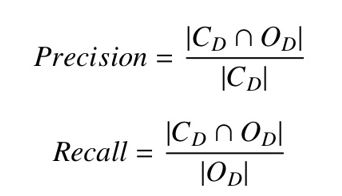

In [61]:
#precision
len(matches)/len(matches)

1.0

In [64]:
in_perfect_map_no_matches = []
for m in a_g_list:
    #list1_for_comparison = list(m)
    if m not in matches:
        in_perfect_map_no_matches.append(m)

In [66]:
TP=len(matches)
#FP=len(pairlist_withno_matches)
#FN-=the pair is same as the perfect mapping, but not in the same manufacter
FN=len(in_perfect_map_no_matches)

In [67]:
Recall=TP/(TP+FN)
Recall

0.03923076923076923

**3.2**: Consolidate the candidate pairs into a **new** single DataFrame referred to as "candidate_pairs". This DataFrame is intended to contain columns from the Amazon and Google datasets that correspond to each group of candidate pairs. Print the first 10 rows of "candidate_pairs".

For each pair, your DataFrame should at least include the following columns:

* 'amazon_id': The unique identifier for the product in the Amazon dataset.
* 'google_id': The unique identifier for the product in the Google dataset.
* 'amazon_name_tfidf': The name of the product from the Amazon dataset.
* 'google_name_tfidf': The name of the product from the Google dataset.
* 'amazon_description_tfidf': The description of the product from the Amazon dataset.
* 'google_description_tfidf': The description of the product from the Google dataset.
* 'amazon_manufacturer_tfidf': The manufacturer of the product from the Amazon dataset.
* 'google_manufacturer_tfidf': The manufacturer of the product from the Google dataset.


In [69]:
list_can_pair=[]

for index,row in pair_list:
    row_new=[]
    for index_a,row_a in amazon.iterrows():
        if row_a["id"] in index:
            row_new.append(row_a["id"])
            row_new.append(row_a["name_cleaned"])
            row_new.append(row_a["description_cleaned"])
            row_new.append(row_a["manufacturer_cleaned"])
    
    for index_g,row_g in google.iterrows():
        if row_g["id"] in row:
            row_new.append(row_g["id"])
            row_new.append(row_g["name_cleaned"])
            row_new.append(row_g["description_cleaned"])
            row_new.append(row_g["manufacturer_cleaned"])
    list_can_pair.append(row_new)


In [72]:
candidate_pairs=pd.DataFrame(list_can_pair,columns=["amazon_id","amazon_name",'amazon_description','amazon_manufacturer',"google_id",'google_name','google_description','google_manufacturer'])

In [73]:
def tfidf_transform_2(df, column, column2):
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(df[column])
    tfidf_2 = vectorizer.transform(df[column2])

    t_list=[]
    t_array=tfidf.toarray()
    #v=vectorizer.vocabulary_
    for x in range(tfidf.shape[0]):
        new=t_array[x]
        t_list.append(new)
    
    t2_list=[]
    t2_array=tfidf_2.toarray()
    #v=vectorizer.vocabulary_
    for x in range(tfidf_2.shape[0]):
        new2=t2_array[x]
        t2_list.append(new2)
    
    return t_list, t2_list


candidate_pairs["amazon_name_tfidf"],candidate_pairs["google_name_tfidf"] = tfidf_transform_2(candidate_pairs, "amazon_name","google_name")
candidate_pairs["amazon_manufacturer_tfidf"],candidate_pairs["google_manufacturer_tfidf"] = tfidf_transform_2(candidate_pairs, "amazon_manufacturer","google_manufacturer")
candidate_pairs["amazon_description_tfidf"],candidate_pairs["google_description_tfidf"] = tfidf_transform_2(candidate_pairs, "amazon_description","google_description")
candidate_pairs.head(10)


,amazon_id,amazon_name,amazon_description,amazon_manufacturer,google_id,google_name,google_description,google_manufacturer,amazon_name_tfidf,google_name_tfidf,amazon_manufacturer_tfidf,google_manufacturer_tfidf,amazon_description_tfidf,google_description_tfidf
0,b0009hl34q,tropico pirate cove mac,tropico pirate cove ruler land full scurvy sea...,destineer inc,http://www.google.com/base/feeds/snippets/1842...,destineer inc scrabble mac later,play one eight challenging computer opponents ...,destineer inc,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,b000cpshfs,everquest titanium,includes original everquest ten expansion pack...,sony creative software,http://www.google.com/base/feeds/snippets/1299...,vegas movie studiodvd plat,sony media software vegas movie studio dvd pla...,sony creative software,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,b000edvrtq,station access collection,really want jump online massive gaming experie...,sony creative software,http://www.google.com/base/feeds/snippets/1299...,vegas movie studiodvd plat,sony media software vegas movie studio dvd pla...,sony creative software,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,b000cpshfs,everquest titanium,includes original everquest ten expansion pack...,sony creative software,http://www.google.com/base/feeds/snippets/1195...,digital video audio prod book,hands guide creating rich multimedia vegas sof...,sony creative software,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,b000edvrtq,station access collection,really want jump online massive gaming experie...,sony creative software,http://www.google.com/base/feeds/snippets/1195...,digital video audio prod book,hands guide creating rich multimedia vegas sof...,sony creative software,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,b000g80lqo,peachtree sage premium accounting nonprofits,peachtree premium accounting nonprofits afford...,sage software,http://www.google.com/base/feeds/snippets/1605...,sage software acts2005rt act,act designed windows xp server server organize...,sage software,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,b000g7wses,peachtree sage premium accounting manufacturin...,peachtree prem manufact mup,sage software,http://www.google.com/base/feeds/snippets/1605...,sage software acts2005rt act,act designed windows xp server server organize...,sage software,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.

**3.3**:Unfortunately, similarity functions are not perfect in practice. For the candidate set you computed in 3.1, calculate similarity scores for each candidate pair formed by: 

(i)  computing  the Cosine Similarity measure between each of the corresponding 'name_tfidf', 'description_tfidf', and 'manufacturer_tfidf' fields in the two records (leading to three cosine sim. scores); 

(ii)  average the three scores to yield a single composite ‘similarity’ score.


Next, we must compute a ‘threshold’ in [0,1], such that for pairs with score >= the threshold, the pair is predicted to be a duplicate; otherwise, the pair is deemed to be a non-duplicate. Consider potential thresholds at increments of 0.1, starting from 0 and ending at 1. At what threshold(s) is the F-measure optimized, and what is the optimized F-measure?


In [74]:
from sklearn.metrics import f1_score

In [75]:
def cosine_similarity(vector1, vector2):
    similarity = np.dot(vector1, vector2)
    normalized_vector1 = np.linalg.norm(vector1)
    normalized_vector2 = np.linalg.norm(vector2)

    similarity = similarity/normalized_vector1 * normalized_vector2
    return similarity

In [76]:
candidate_pairs["name_cos"]=candidate_pairs.apply(lambda x: cosine_similarity(x["amazon_name_tfidf"], x["google_name_tfidf"]),axis=1)
candidate_pairs["manufacturer_cos"]=candidate_pairs.apply(lambda x: cosine_similarity(x["amazon_manufacturer_tfidf"], x["google_manufacturer_tfidf"]),axis=1)
candidate_pairs["description_cos"]=candidate_pairs.apply(lambda x: cosine_similarity(x["amazon_description_tfidf"], x["google_description_tfidf"]),axis=1)
candidate_pairs["similarity"]=(candidate_pairs["name_cos"]+candidate_pairs["manufacturer_cos"]+candidate_pairs["description_cos"])/3

C:\Users\royer\AppData\Local\Temp\ipykernel_18060\460113588.py:6: RuntimeWarning: invalid value encountered in scalar divide
  similarity = similarity/normalized_vector1 * normalized_vector2


In [77]:
candidate_pairs.head(5)

,amazon_id,amazon_name,amazon_description,amazon_manufacturer,google_id,google_name,google_description,google_manufacturer,amazon_name_tfidf,google_name_tfidf,amazon_manufacturer_tfidf,google_manufacturer_tfidf,amazon_description_tfidf,google_description_tfidf,name_cos,manufacturer_cos,description_cos,similarity
0,b0009hl34q,tropico pirate cove mac,tropico pirate cove ruler land full scurvy sea...,destineer inc,http://www.google.com/base/feeds/snippets/1842...,destineer inc scrabble mac later,play one eight challenging computer opponents ...,destineer inc,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.087972,1.0,0.000000,0.362657
1,b000cpshfs,everquest titanium,includes original everquest ten expansion pack...,sony creative software,http://www.google.com/base/feeds/snippets/1299...,vegas movie studiodvd plat,sony media software vegas movie studio dvd pla...,sony creative software,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,1.0,0.000000,0.333333
2,b000edvrtq,station access collection,really want jump online massive gaming experie...,sony creative software,http://www.google.com/base/feeds/snippets/1299...,vegas movie studiodvd plat,sony media software vegas movie studio dvd pla...,sony creative software,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,1.0,0.016164,0.338721
3,b000cpshfs,everquest titanium,includes original everquest ten expansion pack...,sony creative software,http://www.google.com/base/feeds/snippets/1195...,digital video audio prod book,hands guide creating rich multimedia vegas sof...,sony creative software,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,1.0,0.000000,0.333333
4,b000edvrtq,station access collection,really want jump online massive gaming experie...,sony creative software,http://www.google.com/base/feeds/snippets/1195...,digital video audio prod book,hands guide creating rich multimedia vegas sof...,sony creative software,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,1.0,0.008318,0.336106


In [81]:
for thres in range(1, 11):
    t=round(thres * 0.1,2)
    pred_list=candidate_pairs.apply(lambda x: 1 if x["similarity"] > t else 0, axis=1)
    pred = pred_list
    actual = candidate_pairs.apply(lambda x: 1 if ([x["amazon_id"],x["google_id"]]) in a_g_list else 0, axis=1)
    print("threshold",t,", and the f1 score is",f1_score(actual, pred))

threshold 0.1 , and the f1 score is 0.07527675276752768
threshold 0.2 , and the f1 score is 0.07527675276752768
threshold 0.3 , and the f1 score is 0.07527675276752768
threshold 0.4 , and the f1 score is 0.12530712530712532
threshold 0.5 , and the f1 score is 0.264367816091954
threshold 0.6 , and the f1 score is 0.4596273291925466
threshold 0.7 , and the f1 score is 0.26190476190476186
threshold 0.8 , and the f1 score is 0.10526315789473684
threshold 0.9 , and the f1 score is 0.03773584905660377
threshold 1.0 , and the f1 score is 0.0


**A:** So when the threshold is 0.6, the optimized F-measure is 0.4596.

### Objective:
In this follow-up assignment, you will build upon the entity resolution work from HW5. This time, you will incorporate additional similarity metrics and use machine learning models.

### Datasets:
You will continue to use the datasets from HW5:
- Amazon.csv
- Google.csv
- Amazon_GoogleProducts_perfectMapping.csv



### Question 1: More blocking keys 
First, let’s repeat Question 3.2 and 3.3 in HW5, but using the other two blocking keys in Question 2 of HW5. What are their (threshold-optimized) F-measures and how do they compare to the answer in 3.2? Are the optimized thresholds different for each of the methods? **Please only consider blocking strategy 2 (Name Token Blocking)**


For the remainder of the questions in HW6, assume the candidate set generated by the ***Name Token Blocking***

In [85]:
common_name = df_name_compare_a["Key"]
namelist_can_pair=[]
pair_list_name=[]
for name in common_name:
    # print("name",name)
    for i, x in enumerate((google["name_cleaned_token"])):
        if name in x:
            g_id=google["id"][i]
            # print("g_id",g_id)
            for i_2, x_2 in enumerate(amazon["name_cleaned_token"]):
                if name in x_2:
                    a_id=amazon["id"][i_2]
                    # print("a_id",a_id)
                    # print((a_id,g_id))
                    pair_list_name.append((a_id,g_id,name))
                    
                    namelist_can_pair.append((a_id,amazon["name_cleaned"][i_2], amazon["description_cleaned"][i_2], amazon["manufacturer_cleaned"][i_2],g_id,google["name_cleaned"][i],google["description_cleaned"][i],google["manufacturer_cleaned"][i]))


In [90]:
candidate_pairs_name=pd.DataFrame(namelist_can_pair,columns=["amazon_id","amazon_name",'amazon_description','amazon_manufacturer',"google_id",'google_name','google_description','google_manufacturer'])
candidate_pairs_name["amazon_name_tfidf"], candidate_pairs_name["google_name_tfidf"] = tfidf_transform_2(candidate_pairs_name, "amazon_name","google_name")
candidate_pairs_name["amazon_manufacturer_tfidf"],candidate_pairs_name["google_manufacturer_tfidf"] = tfidf_transform_2(candidate_pairs_name, "amazon_manufacturer","google_manufacturer")
candidate_pairs_name["amazon_description_tfidf"],candidate_pairs_name["google_description_tfidf"] = tfidf_transform_2(candidate_pairs_name, "amazon_description","google_description")
candidate_pairs_name["name_cos"]=candidate_pairs_name.apply(lambda x: cosine_similarity(x["amazon_name_tfidf"], x["google_name_tfidf"]),axis=1)
candidate_pairs_name["name_cos"]=candidate_pairs_name.apply(lambda x: 0 if math.isnan(x["name_cos"]) else x["name_cos"],axis=1)
candidate_pairs_name["manufacturer_cos"]=candidate_pairs_name.apply(lambda x: cosine_similarity(x["amazon_manufacturer_tfidf"], x["google_manufacturer_tfidf"]),axis=1)
candidate_pairs_name["manufacturer_cos"]=candidate_pairs_name.apply(lambda x: 0 if math.isnan(x["manufacturer_cos"]) else x["manufacturer_cos"],axis=1)
candidate_pairs_name["description_cos"]=candidate_pairs_name.apply(lambda x: cosine_similarity(x["amazon_description_tfidf"], x["google_description_tfidf"]),axis=1)
candidate_pairs_name["description_cos"]=candidate_pairs_name.apply(lambda x: 0 if math.isnan(x["description_cos"]) else x["description_cos"],axis=1)
candidate_pairs_name["similarity"]=(candidate_pairs_name["name_cos"]+candidate_pairs_name["manufacturer_cos"]+candidate_pairs_name["description_cos"])/3

C:\Users\royer\AppData\Local\Temp\ipykernel_18060\460113588.py:6: RuntimeWarning: invalid value encountered in scalar divide
  similarity = similarity/normalized_vector1 * normalized_vector2
C:\Users\royer\AppData\Local\Temp\ipykernel_18060\460113588.py:6: RuntimeWarning: invalid value encountered in scalar divide
  similarity = similarity/normalized_vector1 * normalized_vector2


In [92]:
for thres in range(1, 11):
    t=round(thres * 0.1,2)
    pred_list=candidate_pairs_name.apply(lambda x: 1 if x["similarity"] > t else 0, axis=1)
    pred = pred_list
    actual= candidate_pairs_name.apply(lambda x: 1 if ([x["amazon_id"],x["google_id"]]) in a_g_list else 0, axis=1)

    print("threshold",t,", and the f1 score is",f1_score(actual, pred))

threshold 0.1 , and the f1 score is 0.25516934046345807
threshold 0.2 , and the f1 score is 0.43504911591355594
threshold 0.3 , and the f1 score is 0.5108616060532096
threshold 0.4 , and the f1 score is 0.35915492957746475
threshold 0.5 , and the f1 score is 0.19523684899241034
threshold 0.6 , and the f1 score is 0.10773397532350286
threshold 0.7 , and the f1 score is 0.0554089709762533
threshold 0.8 , and the f1 score is 0.009668508287292817
threshold 0.9 , and the f1 score is 0.003475842891901286
threshold 1.0 , and the f1 score is 0.0


What are their (threshold-optimized) F-measures and how do they compare to the answer in 3.2?

**A:** The optimized F-measures is around 0.51, and the threshold is 0.3. Compared on the answer in 3.3, name blocking strategy can achevie higher f-1 score

Are the optimized thresholds different for each of the methods?

**A:** Yes, the optimized thresholds from the manufactucer blocking strategy is different from the the optimized thresholds from the name blocking strategy

### Question 2: More Similarity Metrics

We will now explore a different way of computing similarity between the two records in a candidate pair. Calculate the normalized Levenshtein similarity for each pair of fields in the candidate pair (hint: in class, we discussed a method for converting Levenshtein distance to normalized Levenshtein similarity, such that it lies in [0,1]). Create three more columns in the "candidate_pairs" DataFrame: 'name_lev', 'description_lev', 'manufacturer_lev‘. 

Print the first five rows of the new "candidate_pairs" DataFrame.

In [93]:
from Levenshtein import distance as lev


#Feel free to make adjustments to this function according to your needs.

def calculate_levenshtein(row):
    name_distance = lev(row['amazon_name'], row['google_name'])
    description_distance = lev(row['amazon_description'], row['google_description'])
    manufacturer_distance = lev(row['amazon_manufacturer'], row['google_manufacturer'])
    return pd.Series([name_distance, description_distance, manufacturer_distance])


In [94]:
candidate_pairs_name_new=candidate_pairs_name.copy()

for index,row in candidate_pairs_name_new.iterrows():
    x=calculate_levenshtein(row)
    candidate_pairs_name_new.at[index, "name_lev"] = x[0]
    candidate_pairs_name_new.at[index, "description_lev"] = x[1]
    candidate_pairs_name_new.at[index, "manufacturer_lev"] = x[2]


In [95]:
candidate_pairs_name_new.head(5)

,amazon_id,amazon_name,amazon_description,amazon_manufacturer,google_id,google_name,google_description,google_manufacturer,amazon_name_tfidf,google_name_tfidf,...,google_manufacturer_tfidf,amazon_description_tfidf,google_description_tfidf,name_cos,manufacturer_cos,description_cos,similarity,name_lev,description_lev,manufacturer_lev
0,b000hed3f8,brainfood games cranium collection,brain food games cranium collection back bette...,encore software,http://www.google.com/base/feeds/snippets/1344...,encore software brain food games cranium colle...,encore software brain food games cranium colle...,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.455047,0.0,0.444758,0.299935,24.0,1000.0,15.0
1,b000ie8u4g,brain food games cranium collection,back better ever full version games hoyle word...,encore,http://www.google.com/base/feeds/snippets/1344...,encore software brain food games cranium colle...,encore software brain food games cranium colle...,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.2269233453367697, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.813427,0.0,0.272486,0.361971,23.0,992.0,6.0
2,b000io7a9m,brain food games cranium collection,brain food games cranium collection,encore,http://www.google.com/base/feeds/snippets/1344...,encore software brain food games cranium colle...,encore software brain food games cranium colle...,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.813427,0.0,0.610271,0.474566,23.0,161.0,6.0
3,b000hed3f8,brainfood games cranium collection,brain food games cranium collection back bette...,encore software,http://www.google.com/base/feeds/snippets/1730...,encore software brain food games cranium colle...,encore software brain food games cranium colle...,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.455047,0.0,0.444758,0.299935,24.0,1000.0,15.0
4,b000ie8u4g,brain food games cranium collection,back better ever full version games hoyle word...,encore,http://www.google.com/base/feeds/snippets/1730...,encore software brain food games cranium colle...,encore software brain food games cranium colle...,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.2269233453367697, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.813427,0.0,0.272486,0.361971,23.0,992.0,6.0


Refer to the `Amazon_GoogleProducts_perfectMapping.csv` file for the actual matches. Create a new column named 'match' in your "candidate_pairs" DataFrame. If a pair of records (in the candidate set) corresponds to a match i.e., is in the perfectMapping file, label it as 'yes' in the 'match' column. Otherwise, label it as 'no.' Note that, by design, most pairs will actually be no! Furthermore, not every pair in the perfectMapping will be included here. What is the number of ‘false negatives’ that are not included in your dataset? 


In [97]:
candidate_pairs_name_new["match"] = candidate_pairs_name_new.apply(lambda x: "yes" if ([x["amazon_id"],x["google_id"]]) in a_g_list else "no", axis=1)
candidate_pairs_name_new["match"].value_counts()

no     35766
yes     2868
Name: match, dtype: int64

### Question 3: Feature Engineering for Machine Learning

Prepare your feature matrix (X) and labels (y) for the machine learning model. 

Each row in X should correspond to a pair of records and contain the (i) three Levenshtein features calculated in Question 1; (ii) the three cosine similarity features you had computed earlier in HW5; and each entry in y should be the label indicating whether the pair of records is a match. Below is a feature set for each pair, including:

* name_lev: Levenshtein distance between product names.
* description_lev: Levenshtein distance between product descriptions.
* manufacturer_lev: Levenshtein distance between manufacturer names.
* name_tfidf_sim: Cosine similarity of TF-IDF vectors for product names.
* description_tfidf_sim: Cosine similarity of TF-IDF vectors for product descriptions.
* manufacturer_tfidf_sim: Cosine similarity of TF-IDF vectors for manufacturer names.

Print the first five vectors of matrix (X).


In [99]:
columns_to_extract = ['name_lev','description_lev','manufacturer_lev','name_cos','description_cos','manufacturer_cos']
X=candidate_pairs_name_new[columns_to_extract].values.tolist()
y=candidate_pairs_name_new["match"]

In [100]:
X[0:5]

[[24.0, 1000.0, 15.0, 0.4550467125842712, 0.44475838515317967, 0.0],
 [23.0, 992.0, 6.0, 0.8134273792922354, 0.27248584237755685, 0.0],
 [23.0, 161.0, 6.0, 0.8134273792922354, 0.6102713720332433, 0.0],
 [24.0, 1000.0, 15.0, 0.4550467125842712, 0.44475838515317967, 0.0],
 [23.0, 992.0, 6.0, 0.8134273792922354, 0.27248584237755685, 0.0]]

### Question 4: Machine Learning for Entity Resolution

**4.1** : Randomly partition the matrix into a training set containing 80% of duplicates and non-duplicates, and a test set containing the rest. The training set must remain fixed for the experiments in 3.2. In running your code, verify that approximately 80% of the matches and non-matches in your original dataset compiled at the end of Q1 are in the training set. 

In [101]:
from collections import Counter
import random

In [102]:
yes_count=Counter(y).get("yes")
no_count=Counter(y).get("no")
yes_count_train=round(yes_count*0.8)
no_count_train=round(no_count*0.8)

indices_of_no = [i for i, x in enumerate(y) if x == 'no']
indices_of_yes = [i for i, x in enumerate(y) if x == 'yes']

random_picked_no = random.sample(indices_of_no,no_count_train)
random_picked_yes = random.sample(indices_of_yes,yes_count_train)

In [103]:
X_train=[]
y_train=[]
for n in random_picked_no:
    X_train.append(X[n])
    y_train.append(y[n])
for y_y in random_picked_yes:
    X_train.append(X[y_y])
    y_train.append(y[y_y])

X_test=[]
y_test=[]
for tt in range(len(y)):
    if tt not in random_picked_no and tt in indices_of_no:
        X_test.append(X[tt])
        y_test.append(y[tt])
    if tt not in random_picked_yes and tt in indices_of_yes:
        X_test.append(X[tt])
        y_test.append(y[tt])
    

Verify that approximately 80% of the matches and non-matches in your original dataset compiled at the end of Q1 are in the training set. 

In [104]:
print(f'The proportion of matches in the training set is: {y_train.count("yes")/yes_count}')

The proportion of matches in the training set is: 0.799860529986053


In [105]:
print(f'The proportion of non-matches in the training set is: {y_train.count("no")/no_count}')

The proportion of non-matches in the training set is: 0.8000055919029245


**4.2** : Select any three different machine learning models from the sklearn package (e.g., a decision tree-based model, a logistic regression model…) . Train each model using the feature set prepared in Question 2. You will end up with a total of three trained models. 



In [106]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score


In [107]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)

y_pred = clf.predict(X_test)
precision = precision_score(y_test, y_pred, pos_label='yes')
recall = recall_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')
accuracy = accuracy_score(y_test, y_pred)


In [108]:
clf_2 = RandomForestClassifier()
clf_2.fit(X_train, y_train)

y_probs_2 = clf_2.predict_proba(X_test)[:, 1]
auc_2 = roc_auc_score(y_test, y_probs_2)

y_pred_2 = clf_2.predict(X_test)
precision_2 = precision_score(y_test, y_pred_2, pos_label='yes')
recall_2 = recall_score(y_test, y_pred_2, pos_label='yes')
f1_2 = f1_score(y_test, y_pred_2, pos_label='yes')
accuracy_2 = accuracy_score(y_test, y_pred_2)


In [109]:
clf_3 = LogisticRegression()
clf_3.fit(X_train, y_train)

y_probs_3 = clf_3.predict_proba(X_test)[:, 1]
auc_3 = roc_auc_score(y_test, y_probs_3)

y_pred_3 = clf_3.predict(X_test)
precision_3 = precision_score(y_test, y_pred_3, pos_label='yes')
recall_3 = recall_score(y_test, y_pred_3, pos_label='yes')
f1_3 = f1_score(y_test, y_pred_3, pos_label='yes')
accuracy_3 = accuracy_score(y_test, y_pred_3)


c:\Users\royer\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**4.3** : Provide a table below where, for each method, you are providing the AUC, precision, recall, F-measure and accuracy. Based on the numbers, which of these metrics might be problematic for evaluating ER? Why?



In [110]:
d_list=[auc,precision,recall,f1,accuracy]
r_list=[auc_2,precision_2,recall_2,f1_2,accuracy_2]
l_list=[auc_3,precision_3,recall_3,f1_3,accuracy_3]

compare_table=pd.DataFrame([d_list,r_list,l_list],columns=["AUC","precision", "recall", "F-measure","accuracy"],index=["DecisionTreeClassifier()","RandomForestClassifier()","LogisticRegression()"])
compare_table

,AUC,precision,recall,F-measure,accuracy
DecisionTreeClassifier(),0.926892,0.847222,0.850174,0.848696,0.977482
RandomForestClassifier(),0.985700,0.923810,0.844948,0.882621,0.983305
LogisticRegression(),0.951025,0.582386,0.357143,0.442765,0.933221


**A:** I think AUC is the problematic metrics. Based on the compare_table, Logistics Regression has the lowest result compared to other model in all the metrics, except AUC.

**4.4** : Using paired t-tests, can you indicate which (if any) of the three models is significantly better than each of the other two? 

In [111]:
from scipy.stats import ttest_rel

In [112]:
d_vs_r=ttest_rel(d_list,r_list)
d_vs_l=ttest_rel(d_list,l_list)
l_vs_r=ttest_rel(l_list,r_list)

In [113]:
pd.DataFrame([d_vs_r,d_vs_l,l_vs_r],columns=["t-score","p-value"])

,t-score,p-value
0,-2.202419,0.092403
1,2.366652,0.077102
2,-2.814335,0.048104


**A:** </br>
Decision tree vs Random Forest: The p-value is 0.092, which is higher than the threshold(0.05). So there is no difference between two models. </br>
Decision tree vs Logistic Regression: The p-value is 0.077, which is higher than the threshold(0.05). So there is no difference between two models. </br>
Logistic Regression vs Random Forest: p-value(0.048) < the threshold(0.05), so these two models have signifciant difference in the performance metrics.